<a href="https://colab.research.google.com/github/marcelogarret/rna/blob/main/aula10a_forecasting_garret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-05-04 16:00:18--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-05-04 16:00:19 (38.0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



**Dataset Passageiros de Companhias Aéreas**

Registra o número mensal em milhares de passageiros de companhias aéreas dos EUA de 1949 a 1960. É uma série temporal clássica que é geralmente usada para testar métodos de previsão de séries temporais

**Parâmetros do Dataset**

1.   **sequence_length**:  são utilizados 12 meses (1 ano) de dados para prever o número de passageiros no próximo mês. Isso permite capturar a sazonalidade anual, uma característica importante deste dataset.
2.   **sampling_rate**: Cada registro mensal será considerado, sem pular meses, para preservar a continuidade sazonal.
3.   **delay**: A previsão será feita para o mês subsequente, adequada para planejamento e alocação de recursos.

In [2]:
import numpy as np

raw_data = []
with open("airline-passengers.csv") as f:
    f.readline()  # Pula o cabeçalho
    for line in f:
        fields = line.split(',')
        raw_data.append(float(fields[1]))  # Assume que a segunda coluna é o número de passageiros

raw_data = np.array(raw_data)
print("Número total de pontos:", len(raw_data))

Número total de pontos: 144


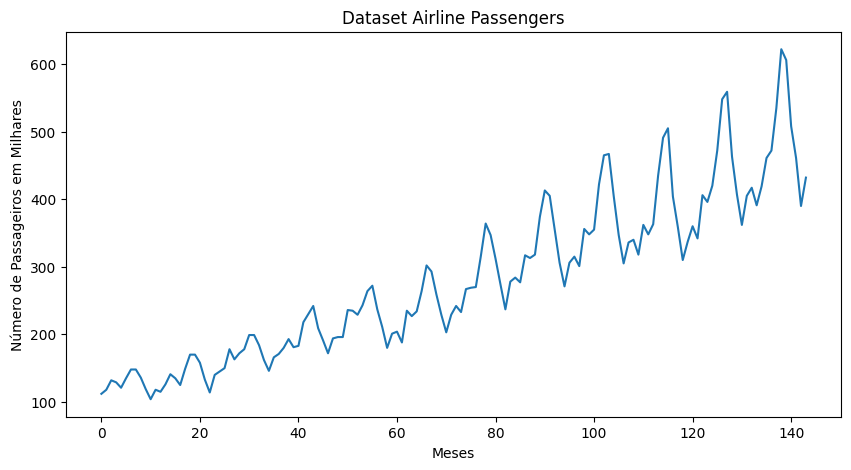

In [3]:
from matplotlib import pyplot as plt

# Gráfico para visualizar dados
plt.figure(figsize=(10, 5))
plt.plot(range(len(raw_data)), raw_data)
plt.title("Dataset Airline Passengers")
plt.xlabel("Meses")
plt.ylabel("Número de Passageiros em Milhares")
plt.show()

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(72, 36, 36)

In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
train_data = raw_data[:num_train_samples]
val_data = raw_data[num_train_samples:num_train_samples + num_val_samples]
test_data = raw_data[num_train_samples + num_val_samples:]

In [7]:
from tensorflow import keras

# Parâmetros para a criação do dataset
sequence_length = 12  # 12 meses para previsão
sampling_rate = 1     # Cada mês é considerado
delay = 1             # Previsão para o próximo mês

train_dataset = keras.utils.timeseries_dataset_from_array(
    train_data[:-delay],
    targets=train_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=128,
    shuffle=True
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    val_data[:-delay],
    targets=val_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=128,
    shuffle=True
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    test_data[:-delay],
    targets=test_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=128,
    shuffle=True
)

In [8]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (60, 12)
targets shape (60,)


#baseline

In [9]:
# Avaliação ingênua (Naive)
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1] # A última observação é usada como previsão
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 1.07
Test MAE: 1.37


#densely conected

In [10]:
from tensorflow.keras import layers

# Dado que estamos tratando de uma série univariada, `raw_data.shape[-1]` é 1
# Configurando o modelo de rede neural
inputs = keras.Input(shape=(sequence_length, 1))  # Modificado para refletir a única série de entrada
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Callback para salvar o modelo com o melhor desempenho baseado no conjunto de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_dense.keras",
                                    save_best_only=True)
]

# Compilação do modelo com otimizador RMSprop, função de perda MSE e acompanhamento do MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_dense.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.3336 - mae: 0.9506 - val_loss: 21.7692 - val_mae: 4.3890
Epoch 2/10
1/1 [==============================] - 1s 630ms/step - loss: 1.1893 - mae: 0.8841 - val_loss: 20.6116 - val_mae: 4.2600
Epoch 3/10
1/1 [==============================] - 0s 419ms/step - loss: 1.1000 - mae: 0.8395 - val_loss: 19.6834 - val_mae: 4.1538
Epoch 4/10
1/1 [==============================] - 1s 502ms/step - loss: 1.0336 - mae: 0.8048 - val_loss: 18.8806 - val_mae: 4.0597
Epoch 5/10
1/1 [==============================] - 0s 481ms/step - loss: 0.9799 - mae: 0.7781 - val_loss: 18.1641 - val_mae: 3.9738
Epoch 6/10
1/1 [==============================] - 0s 315ms/step - loss: 0.9346 - mae: 0.7559 - val_loss: 17.5142 - val_mae: 3.8943
Epoch 7/10
1/1 [==============================] - 0s 177ms/step - loss: 0.8952 - mae: 0.7358 - val_loss: 16.9033 - val_mae: 3.8181
Epoch 8/10
1/1 [==============================] - 0s 298ms/step - loss: 0.8601 - mae: 

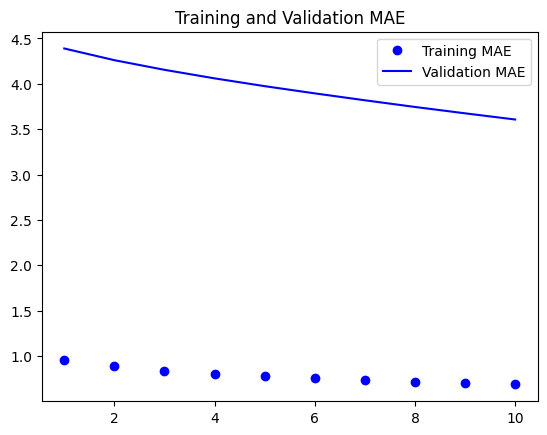

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

#1D convolutional model

In [12]:
# Ajustando o modelo para evitar a redução excessiva de dimensionalidade
inputs = keras.Input(shape=(sequence_length, 1))  # A entrada ainda espera uma única série temporal por amostra
x = layers.Conv1D(16, 3, activation="relu", padding='same')(inputs)  # Usando padding 'same' para manter as dimensões
x = layers.MaxPooling1D(2)(x)  # Aplicando apenas um pooling para reduzir a dimensionalidade
x = layers.Conv1D(16, 3, activation="relu", padding='same')(x)  # Mantendo as dimensões com padding 'same'
x = layers.GlobalAveragePooling1D()(x)  # Global average pooling para resumir as características
outputs = layers.Dense(1)(x)  # Camada de saída
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo baseado no desempenho de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_conv_adjusted.keras",
                                    save_best_only=True)
]

# Compilação do modelo
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_conv_adjusted.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.0085 - mae: 0.8521 - val_loss: 12.0605 - val_mae: 3.3226
Epoch 2/10
1/1 [==============================] - 0s 171ms/step - loss: 0.8950 - mae: 0.7959 - val_loss: 11.1109 - val_mae: 3.1785
Epoch 3/10
1/1 [==============================] - 0s 112ms/step - loss: 0.8204 - mae: 0.7574 - val_loss: 10.3875 - val_mae: 3.0640
Epoch 4/10
1/1 [==============================] - 0s 96ms/step - loss: 0.7615 - mae: 0.7252 - val_loss: 9.7993 - val_mae: 2.9673
Epoch 5/10
1/1 [==============================] - 0s 97ms/step - loss: 0.7102 - mae: 0.6963 - val_loss: 9.2977 - val_mae: 2.8821
Epoch 6/10
1/1 [==============================] - 0s 97ms/step - loss: 0.6646 - mae: 0.6698 - val_loss: 8.8821 - val_mae: 2.8091
Epoch 7/10
1/1 [==============================] - 0s 97ms/step - loss: 0.6235 - mae: 0.6455 - val_loss: 8.5102 - val_mae: 2.7424
Epoch 8/10
1/1 [==============================] - 0s 101ms/step - loss: 0.5870 - mae: 0.6229 -

#Rede Recorrente


In [13]:
# Definindo o modelo LSTM para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(16)(inputs)  # Usando uma camada LSTM com 16 unidades
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm.keras",  # Nome alterado para refletir o novo dataset
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e o métrico MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.7400 - mae: 0.7146 - val_loss: 6.4378 - val_mae: 2.3439
Epoch 2/10
1/1 [==============================] - 0s 99ms/step - loss: 0.7023 - mae: 0.6936 - val_loss: 6.1934 - val_mae: 2.2921
Epoch 3/10
1/1 [==============================] - 0s 93ms/step - loss: 0.6752 - mae: 0.6781 - val_loss: 6.0011 - val_mae: 2.2505
Epoch 4/10
1/1 [==============================] - 0s 97ms/step - loss: 0.6525 - mae: 0.6648 - val_loss: 5.8405 - val_mae: 2.2152
Epoch 5/10
1/1 [==============================] - 0s 135ms/step - loss: 0.6323 - mae: 0.6527 - val_loss: 5.7018 - val_mae: 2.1841
Epoch 6/10
1/1 [==============================] - 0s 97ms/step - loss: 0.6137 - mae: 0.6417 - val_loss: 5.5793 - val_mae: 2.1563
Epoch 7/10
1/1 [==============================] - 0s 95ms/step - loss: 0.5963 - mae: 0.6312 - val_loss: 5.4698 - val_mae: 2.1311
Epoch 8/10
1/1 [==============================] - 0s 95ms/step - loss: 0.5797 - mae: 0.6210 - val_

# dropout-regularized LSTM

In [14]:
# Definindo o modelo LSTM com dropout para prevenção de overfitting
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)  # Usando LSTM com 32 unidades e dropout recorrente
x = layers.Dropout(0.5)(x)  # Dropout após a camada LSTM para reduzir ainda mais o overfitting
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_dropout.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_dropout.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.7393 - mae: 0.7232 - val_loss: 7.2332 - val_mae: 2.4958
Epoch 2/10
1/1 [==============================] - 0s 174ms/step - loss: 0.6322 - mae: 0.6550 - val_loss: 6.8969 - val_mae: 2.4280
Epoch 3/10
1/1 [==============================] - 0s 284ms/step - loss: 0.5546 - mae: 0.6094 - val_loss: 6.6577 - val_mae: 2.3785
Epoch 4/10
1/1 [==============================] - 0s 440ms/step - loss: 0.5358 - mae: 0.5930 - val_loss: 6.4693 - val_mae: 2.3389
Epoch 5/10
1/1 [==============================] - 0s 235ms/step - loss: 0.5104 - mae: 0.5595 - val_loss: 6.2682 - val_mae: 2.2959
Epoch 6/10
1/1 [==============================] - 0s 331ms/step - loss: 0.4227 - mae: 0.5090 - val_loss: 6.0826 - val_mae: 2.2553
Epoch 7/10
1/1 [==============================] - 0s 260ms/step - loss: 0.4445 - mae: 0.5194 - val_loss: 5.9119 - val_mae: 2.2175
Epoch 8/10
1/1 [==============================] - 0s 442ms/step - loss: 0.4104 - mae: 0.5145 

1/1 [==============================] - 1s 504ms/step - loss: 20.7984 - mae: 4.3247
Test MAE: 4.32


#bidirectional LSTM

In [15]:
# Definindo o modelo LSTM Bidirecional para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.Bidirectional(layers.LSTM(16))(inputs)  # LSTM bidirecional com 16 unidades em cada direção
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_bidirectional.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_bidirectional.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.6646 - mae: 0.6732 - val_loss: 6.4300 - val_mae: 2.3238
Epoch 2/10
1/1 [==============================] - 0s 142ms/step - loss: 0.5762 - mae: 0.6202 - val_loss: 6.1819 - val_mae: 2.2699
Epoch 3/10
1/1 [==============================] - 0s 106ms/step - loss: 0.5202 - mae: 0.5839 - val_loss: 5.9814 - val_mae: 2.2254
Epoch 4/10
1/1 [==============================] - 0s 109ms/step - loss: 0.4775 - mae: 0.5548 - val_loss: 5.8088 - val_mae: 2.1864
Epoch 5/10
1/1 [==============================] - 0s 104ms/step - loss: 0.4427 - mae: 0.5322 - val_loss: 5.6548 - val_mae: 2.1510
Epoch 6/10
1/1 [==============================] - 0s 103ms/step - loss: 0.4132 - mae: 0.5122 - val_loss: 5.5138 - val_mae: 2.1182
Epoch 7/10
1/1 [==============================] - 0s 100ms/step - loss: 0.3876 - mae: 0.4937 - val_loss: 5.3823 - val_mae: 2.0871
Epoch 8/10
1/1 [==============================] - 0s 101ms/step - loss: 0.3653 - mae: 0.4763 